# Model Training 

### Import Dependencies

In [15]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio
import soundfile as sf
import sklearn.linear_model
import sklearn.preprocessing
import sklearn.metrics
from multiprocessing import Pool
import random


### Loading Data
Currently, I will be using ASVspoof 2019 dataset which is a dataset containing real (bonafide) and fake (spoofed) speech generated from a variety of methods. 

In [16]:
data_path = '../../data/ASVspoof_Dataset/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt'
df = pd.read_csv(data_path, delimiter=" ", names=["SPEAKER_ID", "AUDIO_FILE_NAME", "SYSTEM_ID", "-", "KEY"])
df.head(5)

,SPEAKER_ID,AUDIO_FILE_NAME,SYSTEM_ID,-,KEY
0,LA_0079,LA_T_1138215,-,-,bonafide
1,LA_0079,LA_T_1271820,-,-,bonafide
2,LA_0079,LA_T_1272637,-,-,bonafide
3,LA_0079,LA_T_1276960,-,-,bonafide
4,LA_0079,LA_T_1341447,-,-,bonafide


### Extracting MFCC Features
This function will extract 13 different mfcc features from each file, and calculate the mean and standard deviation. Then, it will concatnate all values into a single vector.
This snippet also use multiprocessing to speed up the process in parallel.

In [17]:
from mfcc_extraction import extract_mfcc

features = [] # TODO: Use numpy?
if __name__ == '__main__':
    with Pool(os.cpu_count()) as p: # 5min -> 1min 23sec, could optimize more if necessary
        features = p.map(extract_mfcc, df['AUDIO_FILE_NAME'].to_numpy(), len(df) // os.cpu_count())


In [18]:
features = np.array(features)

In [19]:
labels = np.array(df['KEY'].map(lambda x: x == 'bonafide'))

### Extracted Analysis
NOTE: Probably move to data analysis

In [20]:
# sample = pd.DataFrame({"MEAN": features['MEAN'].map(lambda x: x[8]),
#                        "STD": features['STD'].map(lambda x: x[8])})

# sample['KEY'] = labels

# fig, axes = plt.subplots(4, 4, figsize=(25, 25))
# for i in range(13):
#     sample = pd.DataFrame({"MEAN": features['MEAN'].map(lambda x: x[i]),
#                        "STD": features['STD'].map(lambda x: x[i])})
#     sample['KEY'] = labels
#     sns.scatterplot(data=sample, x='MEAN', y='STD', hue='KEY', ax=axes[i//4][i%4])
#     axes[i//4][i%4].set_title(i)
# plt.show()

### Data Normalization
We will use Standard Scaler to normalize our data.
This calculates the z-score or the number of standard deviations a value is from a mean.

z = (x - u) / s
Where x is the value to be normalized, u is the mean, and s is the standard deviation.

In [21]:
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(features)
scaled_featues = scaler.transform(features)

### Build the Model
We will being a logistic regression model for now.

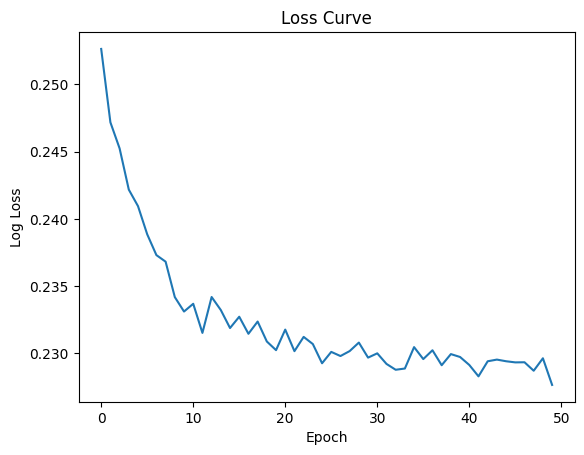

In [22]:


n_epoch = 50 #increasing the epoch tends to move the model to classifying more false files

model = sklearn.linear_model.SGDClassifier(
    loss="log_loss",
    random_state=42,
    max_iter=100,
    warm_start=True,
    shuffle=False,
    class_weight="balanced",
    learning_rate="constant",
    eta0=0.0001
    )

loss_hist = []

for epoch in range(n_epoch):
    i = np.arange(len(scaled_featues))
    random.shuffle(i) # Shuffles dataset every epoch
    features_shuffed = scaled_featues[i]
    labels_shuffed = labels[i]
    model.fit(features_shuffed, labels_shuffed)
    loss = sklearn.metrics.log_loss(labels_shuffed, model.predict_proba(features_shuffed))
    loss_hist.append(loss)

plt.plot(loss_hist)
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.show()

### Load Test Dataset

In [23]:
test_set = '../../data/ASVspoof_Dataset/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.eval.txt'
df_test = pd.read_csv(data_path, delimiter=" ", names=["SPEAKER_ID", "AUDIO_FILE_NAME", "SYSTEM_ID", "-", "KEY"])

labels_test = df_test['KEY'].map(lambda x: x == 'bonafide')
features_test = []
if __name__ == '__main__':
    with Pool(os.cpu_count()) as p: 
        features_test = p.map(extract_mfcc, df_test['AUDIO_FILE_NAME'].to_numpy(), len(df_test) // os.cpu_count())
        features_test = np.array(features_test)
        scaled_features_test = scaler.transform(features_test)

# Generating a Confusion Matrix
As we can see, a lot of real voices were wrongly classified as false, not many were classified as true. 

In [24]:
predictions_test = model.predict(scaled_features_test) 

print(sklearn.metrics.classification_report(labels_test, predictions_test, target_names=["Spoof", "Bonafide"]))

              precision    recall  f1-score   support

       Spoof       0.99      0.90      0.94     22800
    Bonafide       0.52      0.92      0.66      2580

    accuracy                           0.91     25380
   macro avg       0.75      0.91      0.80     25380
weighted avg       0.94      0.91      0.92     25380



0.9053585500394011


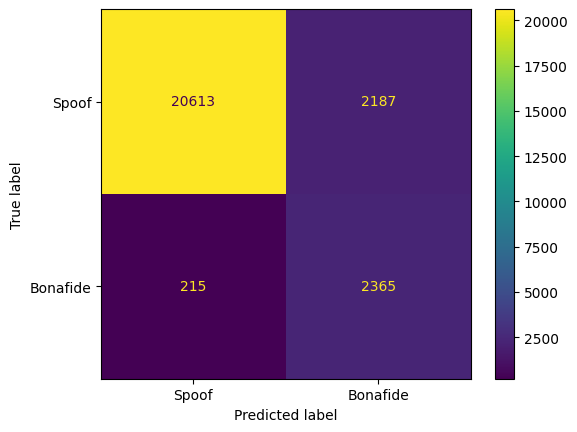

In [25]:
print(sklearn.metrics.accuracy_score(labels_test, predictions_test))

cm = sklearn.metrics.confusion_matrix(labels_test, predictions_test)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Spoof", "Bonafide"])

disp.plot()
plt.show()